In [1]:
# https://stackoverflow.com/questions/37159070/multiple-linear-regression-model-by-using-tensorflow
# https://donaldpinckney.com/books/pytorch/book/ch2-linreg/2018-03-21-multi-variable.html
# https://www.youtube.com/watch?v=Q4GNLhRtZNc
# https://atmamani.github.io/projects/ml/coursera-gd-multivariate-linear-regression/

# Multivariable Linear Regression using frequency data (converted from time series)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import exp

plt.rcParams['figure.figsize'] = [16,12]
plt.rcParams.update({'font.size': 18})

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#generate x-axis for time series based on 30-minute intervals
def get_time_axis(moments):
    x_axis = np.zeros((moments,))
    for col in range(moments):
        x_axis[col] = 30*col #30 minute intervals per day (80 day period)
    return x_axis

In [3]:
#normalize X values to help model converge
def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std
    return data

In [4]:
#split training data
data = np.matrix(pd.read_csv("../archive/exoTrain.csv").values)
training_data_x = data[:, 1:]
training_data_y = data[:,1]
training_data_y-=1

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Frequency')

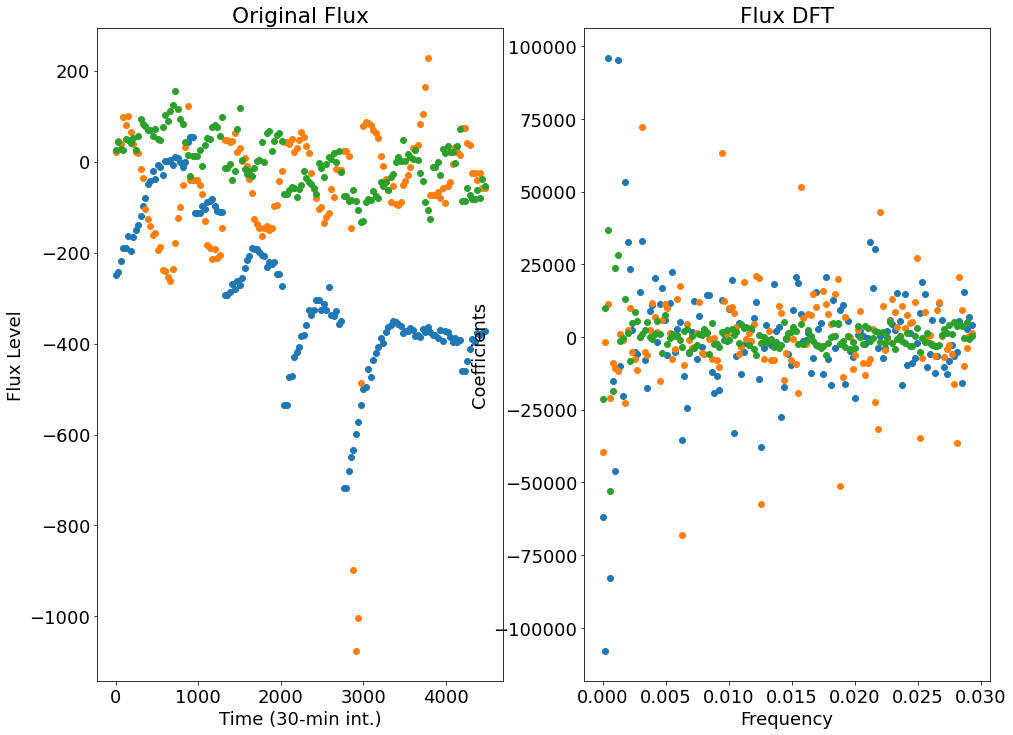

In [5]:
fig,axs = plt.subplots(1,2)
plt.sca(axs[0])
plt.plot(get_time_axis(150), training_data_x[34:37,0:150].transpose(), 'o')
plt.title("Original Flux")
plt.ylabel("Flux Level")
plt.xlabel("Time (30-min int.)")

#convert to frequencies using fft algorithm
training_data_x_fft = np.fft.fft(training_data_x)
freq = np.fft.fftfreq(len(training_data_x))
plt.sca(axs[1])
plt.plot(freq[0:150], training_data_x_fft[34:37,0:150].transpose(), 'o')
plt.title("Flux DFT")
plt.ylabel("Coefficients")
plt.xlabel("Frequency")

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Frequency')

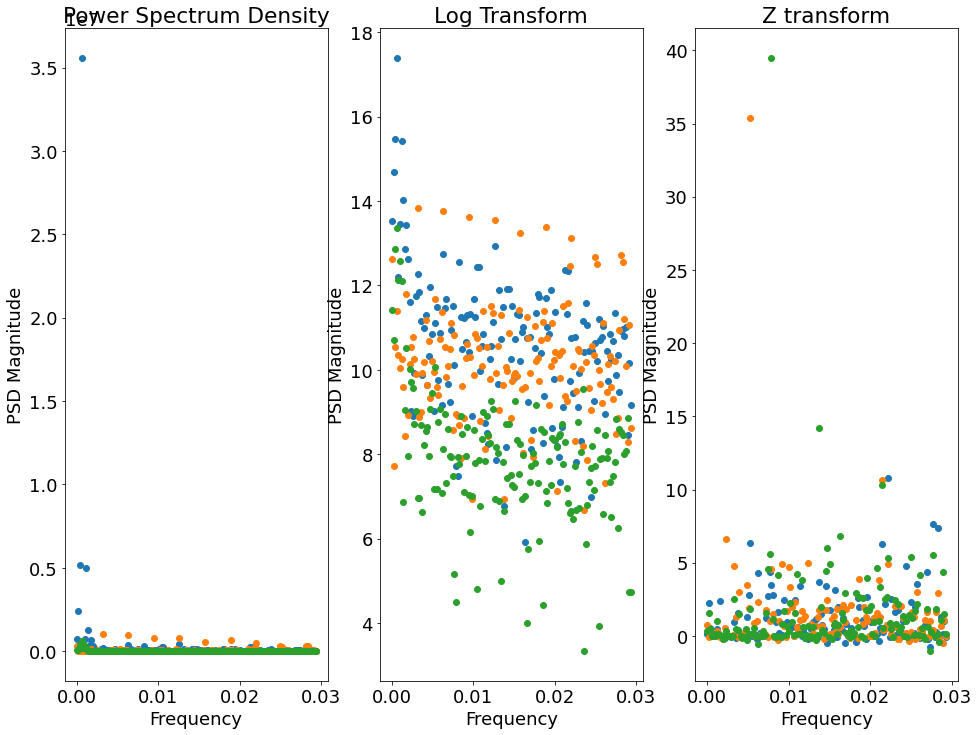

In [6]:
fig,axs = plt.subplots(1,3)

PSD = training_data_x_fft * np.conj(training_data_x_fft)/len(freq)
plt.sca(axs[0])
plt.plot(freq[0:150], PSD[34:37,0:150].transpose(), 'o')
plt.title("Power Spectrum Density")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

#normalize using log transform
PSD_log = np.log(PSD)
plt.sca(axs[1])
plt.plot(freq[0:150], PSD_log[34:37,0:150].transpose(), 'o')
plt.title("Log Transform")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

#normalize using z score
PSD_norm = normalize(PSD.transpose())
plt.sca(axs[2])
plt.plot(freq[0:150], PSD_norm[34:37,0:150].transpose(), 'o')
plt.title("Z transform")
plt.ylabel("PSD Magnitude")
plt.xlabel("Frequency")

Text(0.5, 0, 'Frequency')

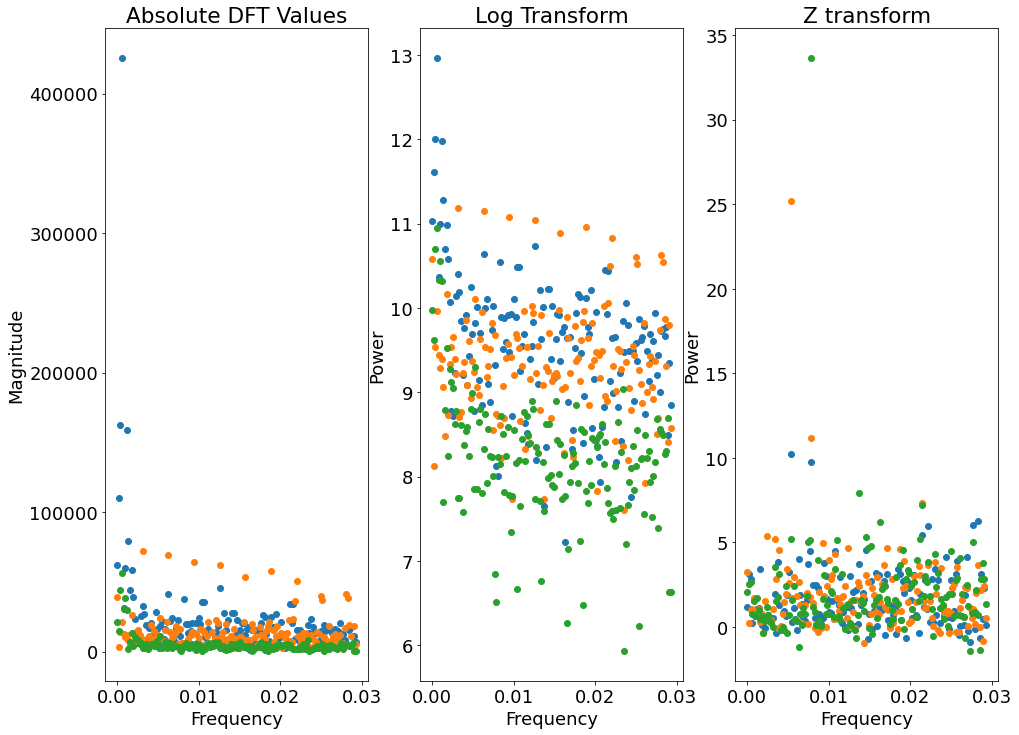

In [7]:
fig,axs = plt.subplots(1,3)

#we don't care about sign (only magnitude)
#also converts complex numbers into magnitudes
training_data_x_fft = np.abs(training_data_x_fft)
plt.sca(axs[0])
plt.plot(freq[0:150], training_data_x_fft[34:37,0:150].transpose(), 'o')
plt.title("Absolute DFT Values")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")

#normalize using log transform
training_data_x_fft_log = np.log(training_data_x_fft)
plt.sca(axs[1])
plt.plot(freq[0:150], training_data_x_fft_log[34:37,0:150].transpose(), 'o')
plt.title("Log Transform")
plt.ylabel("Power")
plt.xlabel("Frequency")

#normalize using z score
training_data_x_fft_norm = normalize(training_data_x_fft.transpose())
plt.sca(axs[2])
plt.plot(freq[0:150], training_data_x_fft_norm[34:37,0:150].transpose(), 'o')
plt.title("Z transform")
plt.ylabel("Power")
plt.xlabel("Frequency")

In [8]:
training_data_x = PSD_norm
training_data_y = training_data_y.transpose()

#set hyperparameters & variables
learning_rate = 0.00001 #0.001 norm
epochs = 500
display_step = 5
n_samples = training_data_x.shape[1]
col_num = training_data_x.shape[0]

X = tf.placeholder(tf.float32, [col_num, n_samples])
Y = tf.placeholder(tf.float32, [1, n_samples])

# We want the weight vector to correspond one to one with every column
W = tf.Variable(tf.zeros([1,col_num], dtype=np.float32), name="weight")
b = tf.Variable(tf.zeros([1, ], dtype=np.float32), name="bias")

pred = tf.matmul(W, X) + b
error = tf.reduce_sum((pred-Y)**2) / (n_samples * 2) #MSE

In [9]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)

session = tf.Session()
session.run(tf.global_variables_initializer())

for t in range(epochs):
    
    _, current_loss, current_W, current_b = session.run([optimizer, error, W, b], feed_dict={
        X: training_data_x,
        Y: training_data_y
    })

    if t % display_step == 0:
        print("t = %g, loss = %g, W = %s, b = %g" % (t, current_loss, str(current_W), current_b))
    
print("Optimization Finished!")

training_error = session.run(error, feed_dict={X: training_data_x, Y: training_data_y})
print("Training error=", training_error, "W=", session.run(W), "b=", session.run(b), '\n')


2021-10-28 18:03:29.635914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:03:29.738357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:03:29.739103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:03:29.740927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

t = 0, loss = 2.31234e+08, W = [[0. 0. 0. ... 0. 0. 0.]], b = 0
t = 5, loss = 2.31217e+08, W = [[-0.07329503  0.61608    -0.07123151 ... -0.1035419  -0.07123151
   0.61608   ]], b = 0.0070539
t = 10, loss = 2.31201e+08, W = [[-0.14918567  1.2215575  -0.14430021 ... -0.20741987 -0.14430021
   1.2215575 ]], b = 0.0138141
t = 15, loss = 2.31186e+08, W = [[-0.22758275  1.8166916  -0.21906133 ... -0.31150803 -0.21906133
   1.8166916 ]], b = 0.0202963
t = 20, loss = 2.3117e+08, W = [[-0.30840087  2.4017317  -0.29537857 ... -0.41568938 -0.29537857
   2.4017317 ]], b = 0.0265152
t = 25, loss = 2.31156e+08, W = [[-0.39155823  2.9769187  -0.37312344 ... -0.5198553  -0.37312344
   2.9769187 ]], b = 0.0324848
t = 30, loss = 2.31142e+08, W = [[-0.4769765   3.5424843  -0.45217508 ... -0.6239051  -0.45217508
   3.5424843 ]], b = 0.0382181
t = 35, loss = 2.31128e+08, W = [[-0.5645805  4.098652  -0.5324196 ... -0.7277455 -0.5324196  4.098652 ]], b = 0.0437277
t = 40, loss = 2.31114e+08, W = [[-0.654298

In [10]:
#Logistic Layer using a sigmoid function
def logistic_layer(y):
    y = np.array(y)
    y = 1 / (1 + exp(-y)) # sigmoid function
    y = y.ravel()
    return y

In [11]:
#Calculate an accuracy metric
def accuracy(predicted_y, true_y):
    true_y = np.array(true_y).ravel()
    counter = 0
    for i in range(len(true_y)):
        p_y = predicted_y[i]
        t_y = true_y[i]
        if (p_y>.5 and t_y == 1) or (p_y < .5 and t_y == 0):
            counter+=1
    counter = (counter/ len(true_y)) * 100
    return counter

In [12]:
test_data = np.matrix(pd.read_csv("../archive/exoTest.csv").values)
test_x = np.log(np.abs(np.fft.fft(test_data[:,1:]))).transpose()
test_y = test_data[:, 0].transpose()
test_y-=1

#accuracy data
predicted_y = np.matmul(session.run(W) ,test_x) + session.run(b)
predicted_y = logistic_layer(predicted_y)

print("Accuracy percentage: ", accuracy(predicted_y, test_y), "%")

Accuracy percentage:  82.80701754385966 %


In [14]:
with open('tf-models/multi-lr-dft.npy', 'wb') as f:
    np.save(f, session.run(W))
    np.save(f, session.run(b))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c58af11-5d4f-40f3-a808-e868f2c28485' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>